# Spectrally Normalized Generative Adversarial Networks (SN-GAN)

*Please note that this is an optional notebook, meant to introduce more advanced concepts if you're up for a challenge, so don't worry if you don't completely follow!*

**Goals**

In this notebook, you'll learn about and implement **spectral normalization**, a weight normalization technique to stabilize the training of the discriminator, as proposed in [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957) (Miyato et al. 2018).

**Background**

As its name suggests, SN-GAN normalizes the weight matrices in the discriminator by their corresponding [spectral norm](https://calculus.subwiki.org/wiki/Spectral_norm#:~:text=The%20spectral%20norm%20of%20a,where%20denotes%20the%20Euclidean%20norm.), which helps control the Lipschitz constant of the discriminator. As you have learned with WGAN, [Lipschitz continuity](https://en.wikipedia.org/wiki/Lipschitz_continuity) is important in ensuring the boundedness of the optimal discriminator. In the WGAN case, this makes it so that the underlying W-loss function for the discriminator (or more precisely, the critic) is valid.

As a result, spectral normalization helps improve stability and avoid vanishing gradient problems, such as mode collapse.

## Spectral Norm

Notationally, the spectral norm of a matrix $W$ is typically represented as $\sigma(W)$. For neural network purposes, this $W$ matrix represents a weight matrix in one of the network's layers. The spectral norm of a matrix is the matrix's largest singular value, which can be obtained via singular value decomposition (SVD).

**A Quick Refresher on SVD**

SVD is a generalization of [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) and is used to factorize a matrix as $W = U\Sigma V^\top$, where $U, V$ are orthogonal matrices and $\Sigma$ is a matrix of singular values on its diagonal. Note that $\Sigma$ doesn't have to be square.

\begin{align*}
    \Sigma = \begin{bmatrix}\sigma_1 & & \\ & \sigma_2 \\ & & \ddots \\ & & & \sigma_n\end{bmatrix}
\end{align*}

where $\sigma_1$ and $\sigma_n$ are the largest and smallest singular values, respectively. Intuitively, larger values correspond to larger amounts of stretching a matrix can apply to another vector. Following this notation, $\sigma(W) = \sigma_1$.

**Applying SVD to Spectral Normalization**

To spectrally normalize the weight matrix, you divide every value in the matrix by its spectral norm. As a result, a spectrally normalized matrix $\overline{W}_{SN}$ can be expressed as

\begin{align*}
  \overline{W}_{SN} = \dfrac{W}{\sigma(W)},
\end{align*}

In practice, computing the SVD of $W$ is expensive, so the authors of the SN-GAN paper do something very neat. They instead approximate the left and right singular vectors, $\tilde{u}$ and $\tilde{v}$ respectively, through power iteration such that $\sigma(W) \approx \tilde{u}^\top W\tilde{v}$.

Starting from randomly initialization, $\tilde{u}$ and $\tilde{v}$ are updated according to

\begin{align*}
  \tilde{u} &:= \dfrac{W^\top\tilde{u}}{||W^\top\tilde{u}||_2} \\
  \tilde{v} &:= \dfrac{W\tilde{v}}{||W\tilde{v}||_2}
\end{align*}

In practice, one round of iteration is sufficient to "achieve satisfactory performance" as per the authors.

Don't worry if you don't completely follow this! The algorithm is conveniently implemented as `torch.nn.utils.spectral_norm` in PyTorch, so as long as you get the general gist of how it might be useful and when to use it, then you're all set.


## A Bit of History on Spectral Normalization

This isn't the first time that spectral norm has been proposed in the context of deep learning models. There's a paper called [Spectral Norm Regularization for Improving the Generalizability of Deep Learning](https://arxiv.org/abs/1705.10941) (Yoshida et al. 2017) that proposes **spectral norm regularization**, which they showed to improve the generalizability of models by adding extra loss terms onto the loss function (just as L2 regularization and gradient penalty do!). These extra loss terms specifically penalize the spectral norm of the weights. You can think of this as *data-independent* regularization because the gradient with respect to $W$ isn't a function of the minibatch.

**Spectral normalization**, on the other hand, sets the spectral norm of the weight matrices to 1 -- it's a much harder constraint than adding a loss term, which is a form of "soft" regularization. As the authors show in the paper, you can think of spectral normalization as *data-dependent* regularization, since the gradient with respect to $W$ is dependent on the mini-batch statistics (shown in Section 2.1 of the [main paper](https://arxiv.org/pdf/1802.05957.pdf)). Spectral normalization essentially prevents the transformation of each layer
from becoming to sensitive in one direction and mitigates exploding gradients.

## DCGAN with Spectral Normalization

In rest of this notebook, you will walk through how to apply spectral normalization to DCGAN as an example, using your earlier DCGAN implementation. You can always add spectral normalization to your other models too.

Here, you start with the same setup and helper function, as you've seen before. 

In [1]:
# Some setup
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

'''
Function for visualizing images: Given a tensor of images, number of images, and
size per image, plots and prints the images in an uniform grid.
'''
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### DCGAN Generator

Since spectral normalization is only applied to the matrices in the discriminator, the generator implementation is the same as the original.

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of the DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating a noise vector: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
    n_samples: the number of samples in the batch, a scalar
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### DCGAN Discriminator

For the discriminator, you can wrap each `nn.Conv2d` with `nn.utils.spectral_norm`. In the backend, this introduces parameters for $\tilde{u}$ and $\tilde{v}$ in addition to $W$ so that the $W_{SN}$ can be computed as $\tilde{u}^\top W\tilde{v}$ in runtime.

Pytorch also provides a `nn.utils.remove_spectral_norm` function, which collapses the 3 separate parameters into a single explicit $\overline{W}_{SN} := \tilde{u}^\top W\tilde{v}$. You should only apply this to your convolutional layers during inference to improve runtime speed.

It is important note that spectral norm does not eliminate the need for batch norm. Spectral norm affects the weights of each layer, while batch norm affects the activations of each layer. You can see both in a discriminator architecture, but you can also see just one of them. Hope this is something you have fun experimenting with!

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

### Training SN-DCGAN

You can now put everything together and train a spectrally normalized DCGAN! Here are all your parameters for initialization and optimization. 

In [4]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Now, initialize the generator, the discriminator, and the optimizers.

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, train the whole thing! And babysit those outputs :)

Step 500: Generator loss: 0.6944725221395496, discriminator loss: 0.6962287451028827


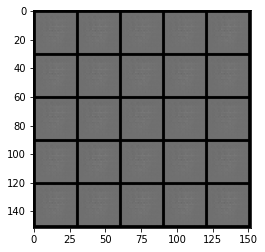

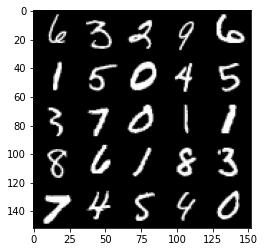

Step 1000: Generator loss: 0.6932769261598588, discriminator loss: 0.6931896638870244


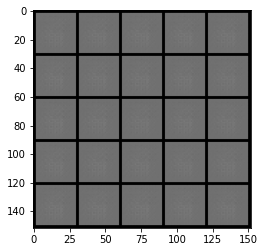

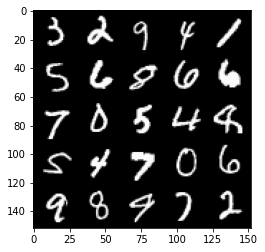

Step 1500: Generator loss: 0.6933206309080127, discriminator loss: 0.6932002656459806


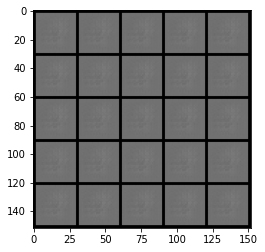

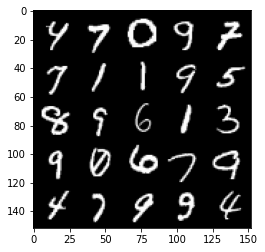

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1